In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.environ['HDF5_DISABLE_VERSION_CHECK']='True'

import pandas as pd

import numpy as np

from scipy import stats
from scipy.stats import ttest_ind

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")



dv = 'percentile'  # options {'percentile', 'REACTION_TIME'}

remove_outliers = False


## clean up the behavioral data

In [2]:
# read in the subject data

df_beh = pd.read_excel("./datasets/dataset_grouping/human_grouping_data.xls")  


# remove the data if the subject id is empty or if it is a practice trial
df_beh = df_beh[(df_beh['trial_type'] == 'exp')]

df_beh

,RECORDING_SESSION_LABEL,Trial_Index_,subj_id,trial_id,block_id,trial_id_block,trial_type,image_id,img_id,image,...,same_diff,close_far,first_dot_xy,second_dot_xy,first_dot_to_image,first_dot_to_second_dot,soa,same_button,REACTION_TIME,RT_EVENT_BUTTON_ID
23,CG01034,24,1,23,0,0,exp,4047,427034,4047_427034.png,...,same,far,"(520, 404)","(720, 406)",500,1000,3,6,1518,7
24,CG01034,25,1,24,0,1,exp,4408,468954,4408_468954.png,...,diff,close,"(514, 386)","(476, 293)",500,1000,3,6,773,6
25,CG01034,26,1,25,0,2,exp,4122,109118,4122_109118.png,...,same,far,"(512, 384)","(416, 563)",500,1000,3,6,1434,6
26,CG01034,27,1,26,0,3,exp,4674,524108,4674_524108.png,...,diff,close,"(511, 384)","(578, 307)",500,1000,3,6,837,6
27,CG01034,28,1,27,0,4,exp,2199,15497,2199_15497.png,...,diff,close,"(512, 384)","(445, 462)",500,1000,3,6,1027,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20659,CG31128,284,31,283,3,59,exp,2172,107087,2172_107087.png,...,diff,far,"(511, 383)","(308, 383)",500,500,1,7,690,6
20660,CG31128,285,31,284,3,60,exp,700,45550,700_45550.png,...,same,far,"(512, 384)","(474, 180)",500,500,1,7,793,6
20661,CG31128,286,31,285,3,61,exp,4390,92939,4390_92939.png,...,diff,close,"(534, 376)","(434, 350)",500,500,1,7,671,6
20662,CG31128,287,31,286,3,62,exp,4138,341973,4138_341973.png,...,same,close,"(503, 387)","(403, 381)",500,500,1,7,586,7


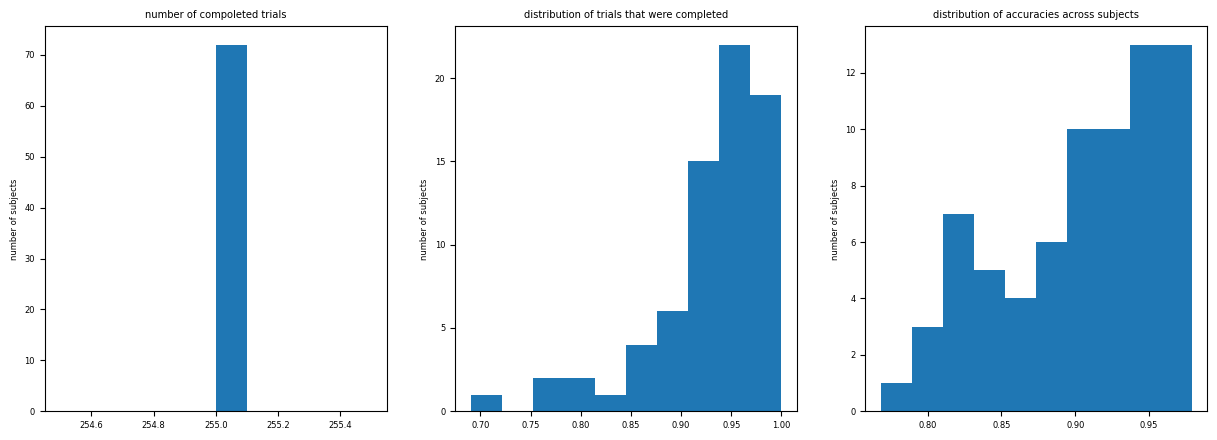

In [3]:
subs = df_beh['RECORDING_SESSION_LABEL'].unique()

acc_subs = np.zeros((len(subs)))
unf_subs = np.zeros((len(subs)))
trials_sub = np.zeros((len(subs)))

for sub in range(len(subs)):
    
    df_sub = df_beh[(df_beh['RECORDING_SESSION_LABEL'] == subs[sub]) ]
    
    trials_sub[sub] = len(df_sub)
    
    df_sub_valid = df_sub[(df_sub['RT_EVENT_BUTTON_ID'] == 6) | (df_sub['RT_EVENT_BUTTON_ID'] == 7)]
    
    unf_subs[sub] = len(df_sub_valid)/len(df_sub)
    
    same_button = df_sub['same_button'].iloc[0]
    
    df_same = df_sub_valid[(df_sub_valid['RT_EVENT_BUTTON_ID'] == same_button) & (df_sub_valid['target'] == 1)]

    df_diff = df_sub_valid[(df_sub_valid['RT_EVENT_BUTTON_ID'] != same_button) & (df_sub_valid['target'] == 0)]
    
    acc = (len(df_same)+len(df_diff))/len(df_sub_valid)
    
    acc_subs[sub] = acc
    
plt.rcParams.update({'font.size': 6})
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 3)
# fig.subplots_adjust(wspace=1, hspace=1)

ax = plt.subplot(gs[0,0])
ax.hist(trials_sub)
ax.set_ylabel('number of subjects')
ax.set_title('number of compoleted trials')

ax = plt.subplot(gs[0,1])
ax.hist(unf_subs)
ax.set_ylabel('number of subjects')
ax.set_title('distribution of trials that were completed')


ax = plt.subplot(gs[0,2])
ax.hist(acc_subs)
ax.set_ylabel('number of subjects')
ax.set_title('distribution of accuracies across subjects')

plt.show()

In [4]:
# remove low accuracy subjects and calculate the percentage of completed trials among them

#we should take out people who did not finis the experiment from the orignial file

valid_subs = subs
df_beh = df_beh[(df_beh['RECORDING_SESSION_LABEL'].isin(valid_subs))]

all_trials = len(df_beh)
df_beh = df_beh[(df_beh['RT_EVENT_BUTTON_ID'] == 6) | (df_beh['RT_EVENT_BUTTON_ID'] == 7)]

print(f'percentage of trials terminated because of fixation moving of center: {1- len(df_beh)/all_trials}')

# create a new column for whether the response was correct or not. 

trial_correct = abs(abs(df_beh['RT_EVENT_BUTTON_ID'].astype('int') - df_beh['same_button'].astype('int')) \
                    -  df_beh['target'].astype('int'))

df_beh['correct'] = list(trial_correct)

acc = np.sum(df_beh['correct']) / len(df_beh['correct'] )
print(f'overall accuracy:{acc}')


df_beh['REACTION_TIME'] = df_beh['REACTION_TIME'].astype('int')

df_beh.head(10)

percentage of trials terminated because of fixation moving of center: 0.06748366013071894
overall accuracy:0.9041527948133871


,RECORDING_SESSION_LABEL,Trial_Index_,subj_id,trial_id,block_id,trial_id_block,trial_type,image_id,img_id,image,...,close_far,first_dot_xy,second_dot_xy,first_dot_to_image,first_dot_to_second_dot,soa,same_button,REACTION_TIME,RT_EVENT_BUTTON_ID,correct
23,CG01034,24,1,23,0,0,exp,4047,427034,4047_427034.png,...,far,"(520, 404)","(720, 406)",500,1000,3,6,1518,7,0
24,CG01034,25,1,24,0,1,exp,4408,468954,4408_468954.png,...,close,"(514, 386)","(476, 293)",500,1000,3,6,773,6,0
25,CG01034,26,1,25,0,2,exp,4122,109118,4122_109118.png,...,far,"(512, 384)","(416, 563)",500,1000,3,6,1434,6,1
26,CG01034,27,1,26,0,3,exp,4674,524108,4674_524108.png,...,close,"(511, 384)","(578, 307)",500,1000,3,6,837,6,0
27,CG01034,28,1,27,0,4,exp,2199,15497,2199_15497.png,...,close,"(512, 384)","(445, 462)",500,1000,3,6,1027,6,0
28,CG01034,29,1,28,0,5,exp,1730,350148,1730_350148.png,...,close,"(512, 384)","(609, 335)",500,1000,3,6,1015,6,1
29,CG01034,30,1,29,0,6,exp,4971,553788,4971_553788.png,...,far,"(509, 383)","(311, 370)",500,1000,3,6,887,7,0
30,CG01034,31,1,30,0,7,exp,1043,73702,1043_73702.png,...,far,"(493, 384)","(292, 422)",500,1000,3,6,720,6,1
31,CG01034,32,1,31,0,8,exp,4196,299887,4196_299887.png,...,far,"(512, 384)","(319, 438)",500,1000,3,6,699,6,0
32,CG01034,33,1,32,0,9,exp,4785,368752,4785_368752.png,...,close,"(520, 368)","(611, 323)",500,1000,3,6,731,6,1


## Across subjects Reaction time Analyses  

In [5]:
# remove outliers -- focusing the analyses on correct trials only

df_beh_c = df_beh[df_beh['correct'] == 1]

for sub in df_beh_c['RECORDING_SESSION_LABEL'].unique():
    
    df_sub = df_beh_c[(df_beh_c['RECORDING_SESSION_LABEL'] == sub)]
    
    z = np.abs(stats.zscore(df_sub['REACTION_TIME'])) < 3
    
    df_beh_c.loc[df_beh_c['RECORDING_SESSION_LABEL'] == sub, 'not_outlier'] = list(z)
    

if remove_outliers:
    df_beh_c = df_beh_c[df_beh_c['not_outlier']  == 1]

In [6]:
# turn rts to percentiles

from scipy.stats import percentileofscore

df_beh_c['percentile'] = 1.0
    
for sub in df_beh_c['RECORDING_SESSION_LABEL'].unique():
    
    df_sub = df_beh_c[df_beh_c['RECORDING_SESSION_LABEL'] == sub]
    
    arr = df_sub['REACTION_TIME']
    arr_sorted = sorted(arr)
    
    percentile_arr = df_sub['REACTION_TIME'].apply(lambda x: percentileofscore(arr_sorted, x))
    
    df_beh_c.loc[df_beh_c['RECORDING_SESSION_LABEL'] == sub, 'percentile'] = list(percentile_arr)
    
df_beh_c


,RECORDING_SESSION_LABEL,Trial_Index_,subj_id,trial_id,block_id,trial_id_block,trial_type,image_id,img_id,image,...,second_dot_xy,first_dot_to_image,first_dot_to_second_dot,soa,same_button,REACTION_TIME,RT_EVENT_BUTTON_ID,correct,not_outlier,percentile
25,CG01034,26,1,25,0,2,exp,4122,109118,4122_109118.png,...,"(416, 563)",500,1000,3,6,1434,6,1,True,92.718447
28,CG01034,29,1,28,0,5,exp,1730,350148,1730_350148.png,...,"(609, 335)",500,1000,3,6,1015,6,1,True,69.417476
30,CG01034,31,1,30,0,7,exp,1043,73702,1043_73702.png,...,"(292, 422)",500,1000,3,6,720,6,1,True,22.330097
32,CG01034,33,1,32,0,9,exp,4785,368752,4785_368752.png,...,"(611, 323)",500,1000,3,6,731,6,1,True,25.728155
33,CG01034,34,1,33,0,10,exp,2774,462031,2774_462031.png,...,"(475, 584)",500,1000,3,6,605,6,1,True,6.067961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20658,CG31128,283,31,282,3,58,exp,4939,507042,4939_507042.png,...,"(642, 228)",500,500,1,7,785,7,1,True,67.857143
20659,CG31128,284,31,283,3,59,exp,2172,107087,2172_107087.png,...,"(308, 383)",500,500,1,7,690,6,1,True,44.047619
20661,CG31128,286,31,285,3,61,exp,4390,92939,4390_92939.png,...,"(434, 350)",500,500,1,7,671,6,1,True,35.476190
20662,CG31128,287,31,286,3,62,exp,4138,341973,4138_341973.png,...,"(403, 381)",500,500,1,7,586,7,1,True,10.476190


In [7]:
# plot average RTs for each condition

summ_rts = []

for cf in ['close', 'far']:
    for sd in ['same', 'diff']:
        sub_summ_rts = []
        for sub in df_beh_c['RECORDING_SESSION_LABEL'].unique():
    
            df_sub = df_beh_c[df_beh_c['RECORDING_SESSION_LABEL'] == sub]

            df_sub_cond = df_sub[(df_sub['close_far']==cf) & (df_sub['same_diff']==sd)]

            sub_summ_rts.append(df_sub_cond['REACTION_TIME'].mean())
            
        summ = np.mean(np.array(sub_summ_rts)), stats.sem(np.array(sub_summ_rts)) #, df_sub_cond['REACTION_TIME'].sem()
        summ_rts.append(summ)

        print(sd, cf,summ)
        
summ_rts = np.array(summ_rts)

same close (830.9843507665836, 18.79283288101963)
diff close (914.5430995843659, 21.91321798759878)
same far (865.9971026588369, 19.467914527601224)
diff far (912.1854738532743, 21.836547876170236)


<Figure size 400x400 with 0 Axes>

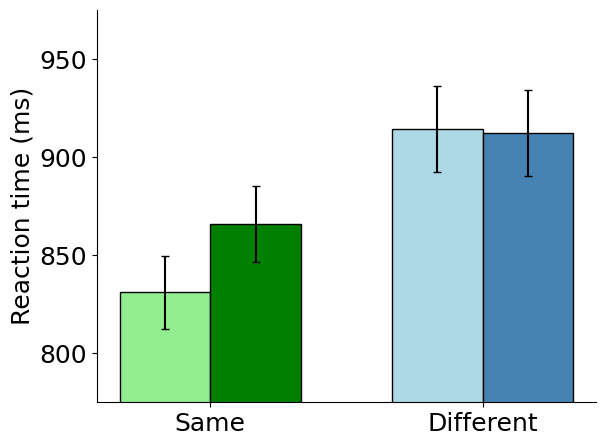

In [8]:
fig = plt.figure(figsize=(4, 4))

labels = ['Same', 'Different']
close_means = summ_rts[0:2,0]
close_ses = summ_rts[0:2,1]

far_means = summ_rts[2:4,0]
far_ses = summ_rts[2:4,1]


x =np.array([0, 1.5])  # the label locations
width = 0.5  # the width of the bars

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, close_means, width, label='Close', edgecolor = 'black', color = ['lightgreen', 'lightblue'], yerr=close_ses, capsize=3)

rects2 = ax.bar(x + width/2, far_means, width, label='Far', edgecolor = 'black', color =['green', 'steelblue'], yerr=far_ses, capsize=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reaction time (ms)')
ax.set_title('')
ax.set_xticks(x)  # , labels=labels
ax.set_xticklabels(labels)
#ax.legend() 
ax.set_ylim(775,975) #(35, 60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()

#fig.savefig("figures/rt_conds_nolegends.png", bbox_inches='tight', dpi=300)

In [9]:
# save the behavioral data
df_beh_c.to_excel("./datasets/dataset_grouping/df_beh_c.xls", index=False)  

### Process subject data for a given trial and store individual and average behavior 

In [10]:
# calcualte average response across all subjects 

df_comp = pd.read_excel("./datasets/dataset_grouping/test_data_grouping.xls", index_col=0)  

# calculate mean subject behavior 

df_comp['subs_mean_rt'] = -1
df_comp['subs_mean_p'] = -1

for t in range(len(df_comp)):

    img_id = df_comp['img_id'].iloc[t]
    sd = df_comp['same_diff'].iloc[t]
    cf = df_comp['close_far'].iloc[t]

    df_t = df_beh_c[(df_beh_c['img_id']==img_id) & (df_beh_c['same_diff']==sd) \
                            & (df_beh_c['close_far']==cf)]

    if not df_t.empty:
        df_comp['subs_mean_rt'].iloc[t] = df_t['REACTION_TIME'].mean()
        df_comp['subs_mean_p'].iloc[t] = df_t['percentile'].mean()
        
        
        
df_comp.to_excel("./datasets/dataset_grouping/test_data_grouping_with_mean_beh.xls")  
# calculate individual subject behavior 

c_subs = df_beh_c['RECORDING_SESSION_LABEL'].unique()

for sub_id in c_subs:

    df_comp[sub_id] = -1
    df_comp[str(sub_id)+'_p'] = -1
    
    for t in range(len(df_comp)):

        img_id = df_comp['img_id'].iloc[t]
        sd = df_comp['same_diff'].iloc[t]
        cf = df_comp['close_far'].iloc[t]

        df_t = df_beh_c[(df_beh_c['img_id']==img_id) & (df_beh_c['same_diff']==sd) \
                                & (df_beh_c['close_far']==cf) & (df_beh_c['RECORDING_SESSION_LABEL']==sub_id)]

        if not df_t.empty:
            df_comp[sub_id].iloc[t] = df_t['REACTION_TIME']
            df_comp[str(sub_id)+'_p'].iloc[t] = df_t['percentile']


df_comp.to_excel("./datasets/dataset_grouping/test_data_grouping_with_all_beh.xls")  